In [2]:
import tqdm
from iqoptionapi.stable_api import IQ_Option
import json 
import statistics
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections as cll
import scipy.stats

connector =IQ_Option("ww.bingonemo@gmail.com","JF*#3C5va&_NDqy")
connector.connect()

(True, None)

In [3]:
seconds_in_month = 2_592_000 
seconds_in_year = 31_536_000
max_dict = 1000
iqcomb = [("NZD", "SEK"),("NZD", "USD"),("CAD", "TRY"),("EUR", "CHF"),("USD", "THB"),("EUR", "TRY"),("GBP", "AUD"),("AUD", "USD"),("EUR", "MXN"),("USD", "CHF"),("NOK", "DKK"),("EUR", "NOK"),("SEK", "JPY"),("CAD", "NOK"),("NOK", "SEK"),("GBP", "HUF"),("GBP", "SGD"),("AUD", "NZD"),("GBP", "JPY"),("CHF", "SEK"),("AUD", "NOK"),("GBP", "NOK"),("AUD", "DKK"),("EUR", "AUD"),("AUD", "CHF"),("GBP", "CHF"),("AUD", "CAD"),("CHF", "DKK"),("AUD", "TRY"),("NZD", "CHF"),("USD", "SEK"),("GBP", "NZD"),("EUR", "DKK"),("NZD", "DKK"),("CAD", "SGD"),("EUR", "GBP"),("EUR", "CAD"),("USD", "CZK"),("AUD", "MXN"),("EUR", "NZD"),("GBP", "PLN"),("NZD", "NOK"),("AUD", "SGD"),("GBP", "SEK"),("NZD", "CAD"),("NZD", "MXN"),("NZD", "TRY"),("CHF", "SGD"),("USD", "MXN"),("EUR", "HUF"),("GBP", "CAD"),("USD", "TRY"),("USD", "JPY"),("EUR", "USD"),("AUD", "SEK"),("CHF", "NOK"),("USD", "PLN"),("USD", "HUF"),("CHF", "JPY"),("GBP", "ILS"),("NZD", "JPY"),("CHF", "TRY"),("CAD", "JPY"),("USD", "RUB"),("SGD", "JPY"),("GBP", "USD"),("CAD", "PLN"),("DKK", "SGD"),("NZD", "SGD"),("AUD", "JPY"),("NOK", "JPY"),("PLN", "SEK"),("USD", "SGD"),("GBP", "MXN"),("USD", "CAD"),("SEK", "DKK"),("DKK", "PLN"),("CAD", "MXN"),("GBP", "TRY"),("EUR", "SGD"),("NZD", "ZAR"),("EUR", "CZK"),("EUR", "JPY"),("CAD", "CHF"),("USD", "INR"),("USD", "BRL"),("USD", "NOK"),("USD", "DKK")]
candle_size = 3600 # 3600 is one hour
quantity =  seconds_in_year / candle_size

In [4]:
end_from_time=time.time()
ANS=[]
for i in tqdm.tqdm(range(int(quantity/max_dict) + 1)):
    data=connector.get_candles("BTCUSD", candle_size, max_dict, end_from_time)
    ANS =data+ANS
    end_from_time=int(data[0]["from"])-1
print(ANS[0], len(ANS))
%store ANS

100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

{'id': 27270, 'from': 1607547600, 'at': 1607551200024203182, 'to': 1607551200, 'open': 18341.015, 'close': 18519.365, 'min': 18326.045, 'max': 18549.995, 'volume': 3180.992664} 9000
Stored 'ANS' (list)


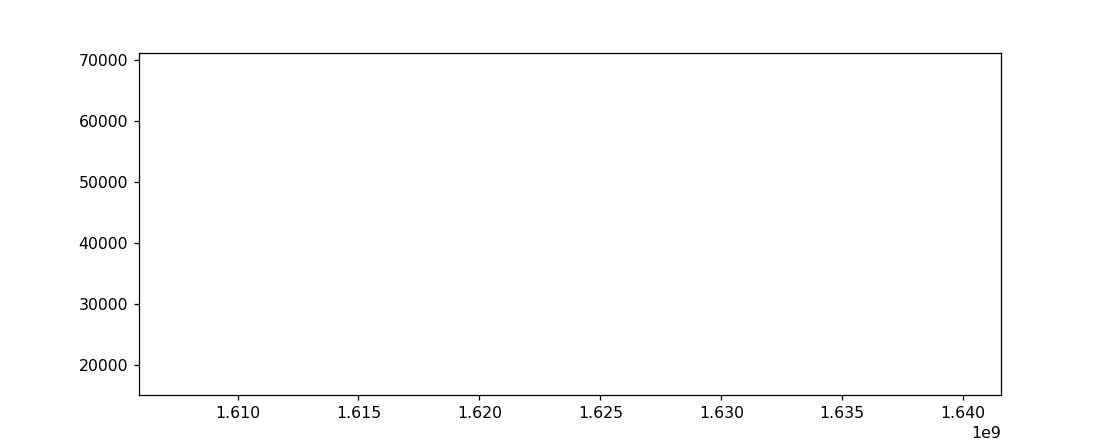

In [5]:
%matplotlib widget
cm = 1/2.54  # centimeters in inches

fig = plt.figure(figsize=(25*cm, 10*cm), dpi=113)
ax = fig.add_subplot()
ax.scatter([x['from'] for x in ANS], [x['close'] for x in ANS], marker= 's' , s=0.29, color=(1, 0, 0))


In [6]:
connector.change_balance("PRACTICE")
instrument_type="crypto"
side="buy"
type_market="market"
limit_price=None 
stop_price=None 
stop_lose_kind=None 
stop_lose_value=None 
take_profit_kind='percent' 
take_profit_value=6
use_trail_stop=False 
auto_margin_call=True 
use_token_for_commission=False 

In [8]:
def custom_crypto(connector, f):
    candles = connector.get_candles(f[:6], 5, 1, time.time())
    return candles[-1]['close']

def custom_crypto_bid(connector, f):
    connector.start_candles_stream(f[:6], 1, 1)
    candles = connector.get_realtime_candles(f[:6], 1)
    bid = [candles[x].get("bid") for x in candles]
    return bid[0]

def custom_profit(connector):
    data = connector.get_positions('crypto')
    price_ref = {}
    total_profit = 0
    total_margin = 0
    for position in data[1].get('positions'):
        inst_id = position.get('instrument_id')
        leverage = position.get('leverage')
        buy_price = position.get('open_underlying_price')
        margin = position.get('margin')
        if inst_id not in price_ref:
            cprice = custom_crypto_bid(connector, inst_id)
            price_ref[inst_id] = cprice
        
        profit = (price_ref[inst_id] - buy_price )*leverage*margin/buy_price
        total_profit += profit
        total_margin += margin

    return total_profit, total_margin, data[1].get('positions')

def custom_crypto_leverage(connector, f, prc):
    if prc:
        return max(connector.get_available_leverages('crypto', f)[1].get('leverages')[0].get('regulated'))
    else:
        return min(connector.get_available_leverages('crypto', f)[1].get('leverages')[0].get('regulated'))

def custom_close(connector, position):
    posid = position.get('order_ids')[0]
    connector.close_position(posid)


In [9]:
custom_crypto(connector, 'BTCUSD')

46760.906

In [10]:
custom_crypto_bid(connector, 'BTCUSD')

46712.588

In [11]:
custom_crypto_leverage(connector, 'BTCUSD', True)

3

In [12]:
check,id=connector.buy_order(instrument_type= instrument_type, instrument_id='BTCUSD',
                    side=side, amount=1,leverage=3,
                    type=type_market,limit_price=limit_price, stop_price=stop_price,
                    stop_lose_value=stop_lose_value, stop_lose_kind=stop_lose_kind,
                    take_profit_value=take_profit_value, take_profit_kind=take_profit_kind,
                    use_trail_stop=use_trail_stop, auto_margin_call=auto_margin_call,
                    use_token_for_commission=use_token_for_commission)

In [17]:
p, m, msg = custom_profit(connector)


In [18]:
custom_close(connector, msg[0])